### Introduction
The purpose of this project is to apply techniques from topological data analysis, namely persistent homology and the mapper algorithm, to investigate the underlying structure of the 17 dimensional dataset. These techniques are taken from algebraic topology. The dataset consists of 569 different tumors which are classified as either benign or malignant according to the diagnosis column.  
The homology tools are taken from the Ripser package presented in *Tralie et al., (2018). Ripser.py: A Lean Persistent Homology Library for Python. Journal of Open Source Software, 3(29), 925, https://doi.org/10.21105/joss.00925*, and the implementation of the mapper algorithm is the Kepler mapper presented in *van Veen et al., (2019). Kepler Mapper: A flexible Python implementation of the Mapper algorithm.. Journal of Open Source Software, 4(42), 1315, https://doi.org/10.21105/joss.01315*.

In [1]:
# import modules
from ripser import Rips
import kmapper as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import persim
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import sklearn

In [2]:
# get data
url = 'https://raw.githubusercontent.com/mwaterman09/Data_Analysis/main/Cancer_Data.csv'
df = pd.read_csv(url)
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [3]:
# get rid of unused columns
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

In [4]:
# encode string diagnoses to binary values
encoder = LabelEncoder()
encoder.fit(df['diagnosis'])
df['diagnosis'] = encoder.transform(df['diagnosis'])
print(encoder.classes_)

['B' 'M']


### Persistent Homology

In [5]:
# create persistent homology object
rips = Rips(maxdim=2)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Homology groups are used to classify the connectivity of a simplicial complex. Each point in the dataset forms a vertex (0-simplex) in the high dimensional feature space. An $\epsilon$ radius is grown around each vertex until the radii begin to overlap with neighboring $\epsilon$ radii, at which point an edge is drawn between vertices creating a 1-simplex. As $\epsilon$ grows, the vertices form more connections creating higher dimensional simplices. The kth homology group denoted $H_k$ is the number of k-dimensional holes in the structure. The first three correspond to the following:
* $H_0$: Fully connected components (i.e. solid spheres)
* $H_1$: Holes (donuts)
* $H_2$: Cavities (holes that are fully enclosed like a hollow sphere)  

On the persistance diagram, the number of $H_k$ groups is computed as $\epsilon$ grows and the birth and death time of each feature is recorded. Values along the main diagonal correspond to noise in the data, while values to the upper left of the diagonal correspond to features that *persist* and thus are significant.

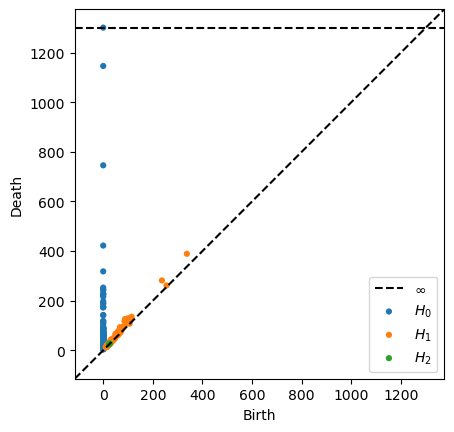

In [6]:
# plot homology diagram
diagram1 = rips.fit_transform(df.values)
rips.plot(diagram1)

The homology diagram above shows that the only persistent homology is of group $H_0$, or fully connected components with only noisey samples of group $H_1$. The underlying shape of the data is fully connected.  

Next we will see if removing the binary value column of 'diagnosis' has any effect on the homology.

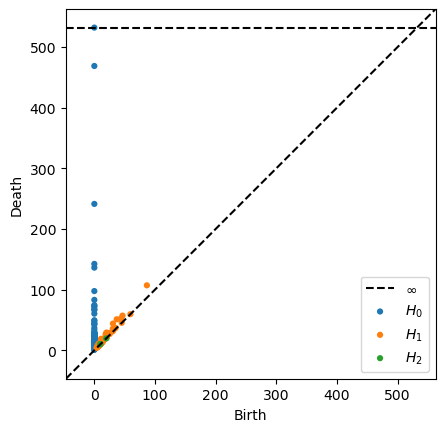

In [7]:
# create second diagram excluding diagnosis column
diagram2 = rips.fit_transform(df.iloc[:, 2:18].values)
rips.plot(diagram2)

The removal of the diagnosis column had little effect on the homology. Next we will check to see if normalizing the data has any effect.

In [8]:
# scale the data
scaler = StandardScaler()
scaler.fit(df.iloc[:, 2:18].values)
scaler.transform(df.iloc[:, 2:18].values)

array([[-2.07333501,  1.26993369,  0.9843749 , ..., -0.21400165,
         1.31686157,  0.72402616],
       [-0.35363241,  1.68595471,  1.90870825, ..., -0.60535085,
        -0.69292627, -0.44078006],
       [ 0.45618695,  1.56650313,  1.55888363, ..., -0.29700501,
         0.8149735 ,  0.21307643],
       ...,
       [ 2.0455738 ,  0.67267578,  0.57795264, ..., -0.37934168,
         0.66127727,  0.5108265 ],
       [ 2.33645719,  1.98252415,  1.73521799, ..., -0.17299998,
         2.01771639,  1.30228464],
       [ 1.22179204, -1.81438851, -1.34778924, ...,  0.04934236,
        -1.16351619, -1.05750068]])

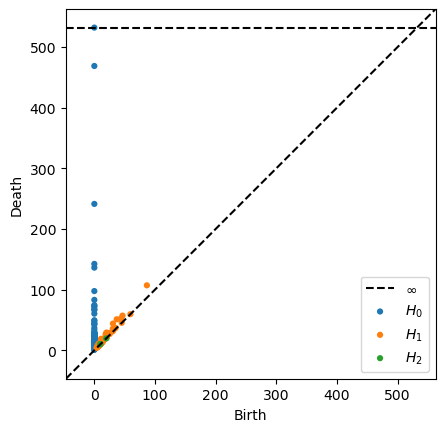

In [9]:
# persistent homology of scaled data
diagram3 = rips.fit_transform(df.iloc[:, 2:18].values)
rips.plot(diagram3)

Scaling the data had little effect and thus we can conclude the underlying shape of the data is fully connected without significant loops or cavities.

### Mapper
In the next section we use the Kepler Mapper implementation to perform a connectivity analysis. The mapper algorithm outputs a graph which preserves the underlying structure of the dataset. It does this by projecting the dataset down into lower dimensional space through the use of a filter function, creating a series of *covers* overlapping each other and containing the entire projected dataset, and then clustering the preimage of the filter according to the covers. A graph is then produced from the clusters, with vertices representing each cluster and edges representing clusters that overlap. The vertices are colored according to the percentage composition of benign or malignant diagnoses.

In [10]:
# initialize mapper
mapper = km.KeplerMapper(verbose=1)

KeplerMapper(verbose=1)


In [11]:
# fit and transform
from sklearn.decomposition import PCA
projected_data1 = mapper.fit_transform(df.iloc[:, 0:18].values, projection=PCA(n_components=1), scaler=None)
projected_data2 = mapper.fit_transform(df.iloc[:, 0:18].values, projection='knn_distance_5', scaler=None)

# create 2d lens
projected_data = np.c_[projected_data1, projected_data2]

..Composing projection pipeline of length 1:
	Projections: PCA(n_components=1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (569, 18)

..Projecting data using: 
	PCA(n_components=1)

..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (569, 18)

..Projecting data using: knn_distance_5


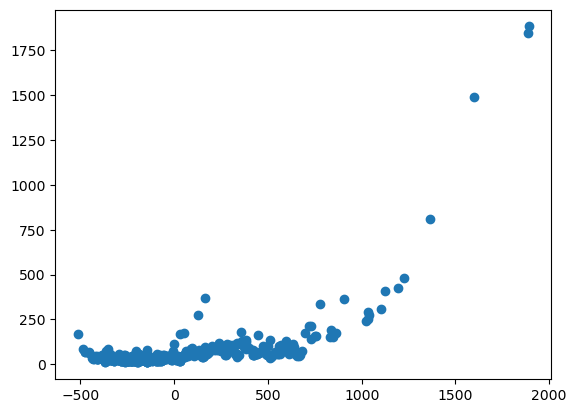

In [12]:
# visualize lens
plt.scatter(projected_data1, projected_data2)

In [13]:
# create dictionary with nodes and edges
import warnings
warnings.filterwarnings('ignore') 
graph = mapper.map(projected_data, df.iloc[:, 0:18].values, 
                   clusterer=sklearn.cluster.KMeans(n_clusters=2, n_init='auto'),
                   cover=km.Cover(n_cubes=50, perc_overlap=0.7));

Mapping on data shaped (569, 18) using lens shaped (569, 2)

Creating 2500 hypercubes.

Created 2727 edges and 340 nodes in 0:00:17.456067.


In [14]:
# visualize
from kmapper.jupyter import display
mapper.visualize(graph, 
                 color_values=(df.iloc[:, 0].values), 
                 color_function_name="Tumor type",
                 node_color_function='mean',
                 path_html="OutputMapper.html", 
                 title="Analysis of Benign vs Malignant Tumors");

Wrote visualization to: OutputMapper.html


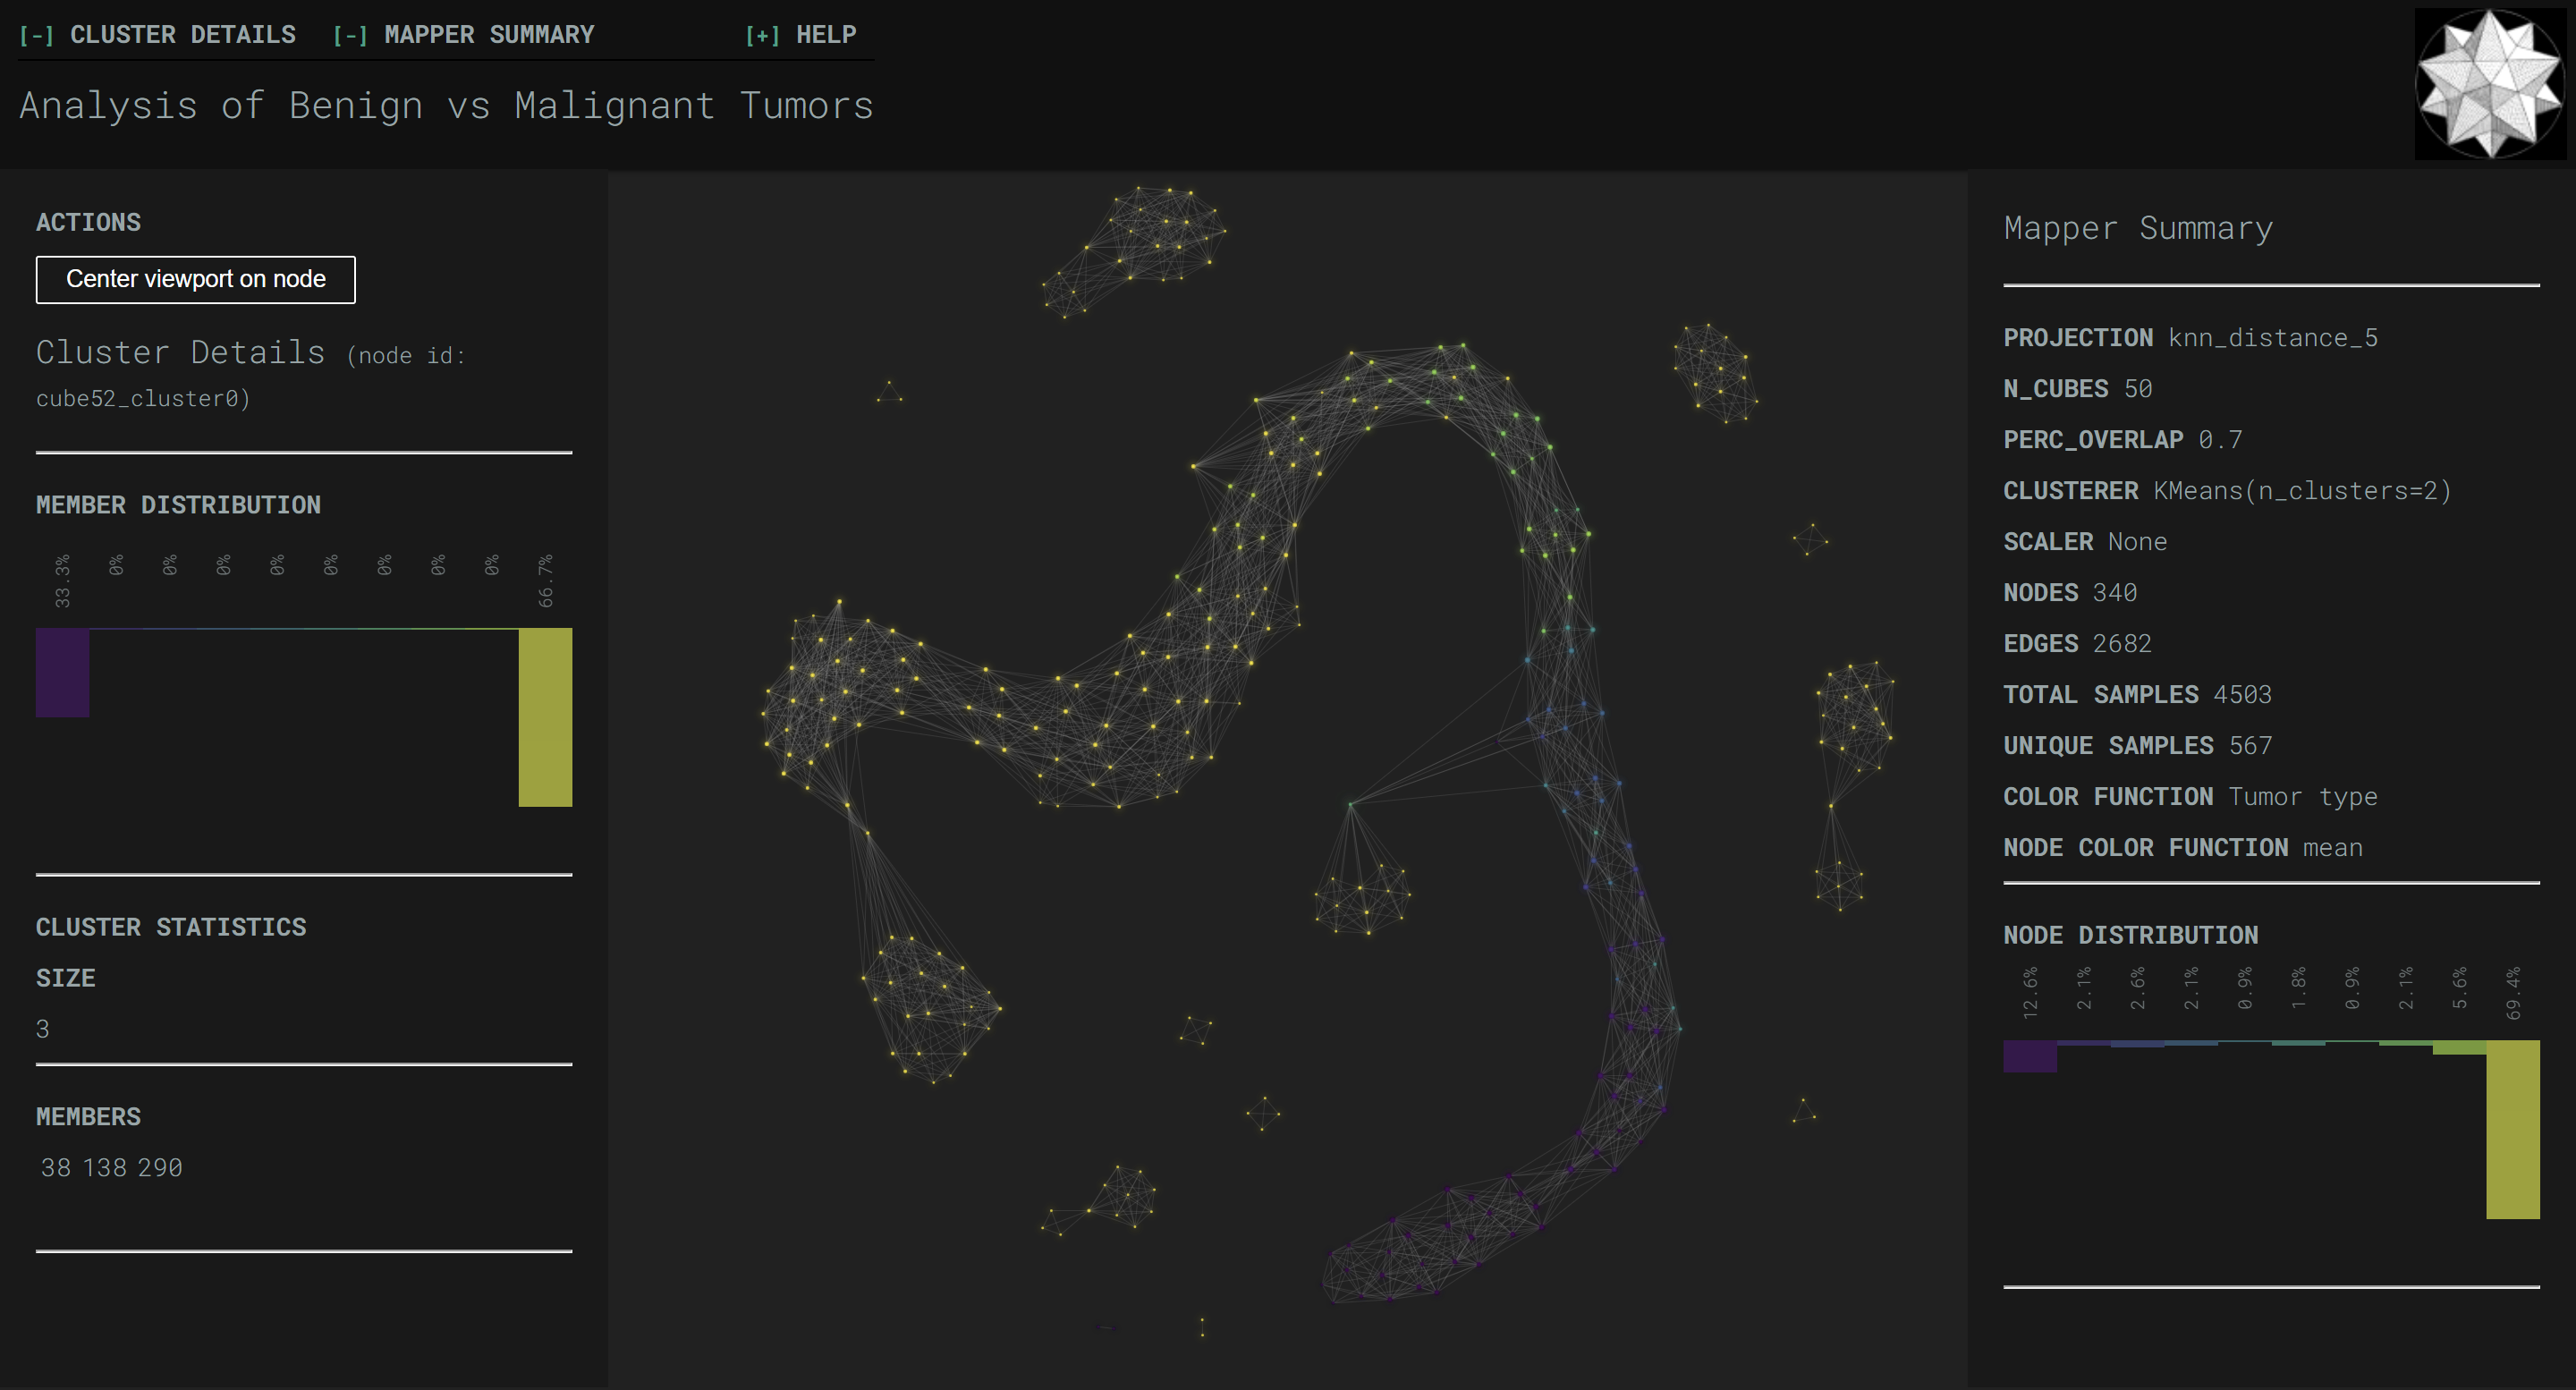

This is the result of Mapper. Each vertex represents a cluster and the clusters are colored according to their average composition of either benign (purple) or malignant (yellow) diagnoses. The vertices consist of primarily either benign or malignant diagnoses with a few vertices containing combinations of both.  

This graph agrees with the result of the persistant homology diagram which did not reveal any underlying loops or holes in the shape of the dataset. The most prominent structure is the large elongated cluster containing the majority of samples. This structure reveals a spectrum of cluster colors ranging from yellow to purple. In each cluster the members are listed by their index position in the dataframe. An interesting feature to note is the offshoot in the center consisting of yellow nodes. The members of this structure are shown on the left of the image: indices 38, 138, and 290. These members may be further investigated to determine why they belong to this unique subgroup. 